In [2]:
using DrWatson
@quickactivate "projectdir()"

  Activating project at `/storage/work/s/suv87/julia/grdpg`


In [5]:
using StatsBase, Pipe, Graphs, GraphIO, LightGraphs, Suppressor, ProgressBars
using LinearAlgebra, Distances, Manifolds, Distributions, LaTeXStrings
using Plots, Clustering, Ripserer, PersistenceDiagrams, PersistenceDiagramsBase
using Manopt
theme(:dao)

In [6]:
include("./src/rdpg.jl")
import Main.rdpg

### Latent Space

Latent space consists of $n=1200$ points sampled from two concentric circles, i.e. $\mathbb{X} = \partial B(0, 0.5) \cup \partial B(0, 0.9)$ with labels 
$$
\text{label}(\boldsymbol{x}) = \begin{cases}
0 & \text{  if }\boldsymbol{x} \in \partial B(0, 0.9)\\
1 & \text{  if }\boldsymbol{x} \in \partial B(0, 0.5)
\end{cases}
$$

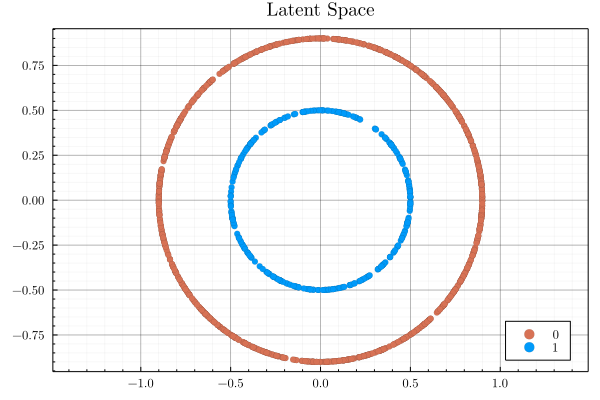

In [7]:
n = 300;
d = 1;
M = Sphere(d); # Define the circle using the Manifolds package
μ = [0, 1, 0]  # repeat([0.5], 3)
Z1 = [tuple(([random_point(M)...] .* 0.9)...) for i in 1:(3*n)]
Z2 = [tuple(([random_point(M)...] .* 0.5)...) for i in 1:n]
Z = [Z1; Z2]
labels = [repeat([0], length(Z1)); repeat([1], length(Z2))]
plt0 = @pipe Z |> scatter(_, group=labels, aspect_ratio = :equal, title = "Latent Space", legend=:bottomright)

The adjecency matrix $A \sim \text{gRDPG}(\mathbb P, \mathbb X_n)$

In [8]:
f = (x, y) -> abs.((dot([x...], [y...])))
A = rdpg.Adjacency(f, Z);

The spectral embedding $\widehat{\mathbb{X}}_n = \textsf{spectral}(A)$ is illustrated below. 

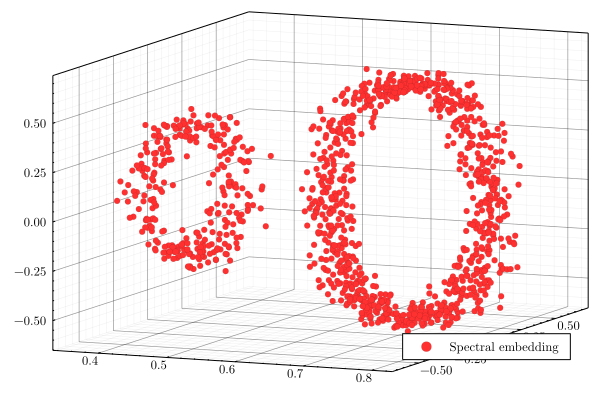

In [9]:
X, _ = rdpg.spectralEmbed(A, scale = false, d = 3)
plt1 = @pipe X |> rdpg._Matrix_to_ArrayOfTuples |> scatter(_, c=:firebrick1, label="Spectral embedding", legend=:bottomright)

For $\epsilon=2$, the $\epsilon-$ differentially private graph $B = \mathcal{M}_{\epsilon}(A)$, and the privacy-adjusted spectral embedding $\widehat{\mathbb{Y}}_n = \mathsf{spectral} \circ \mathcal{M}^{\star}_{\epsilon}(B)$ are below. 

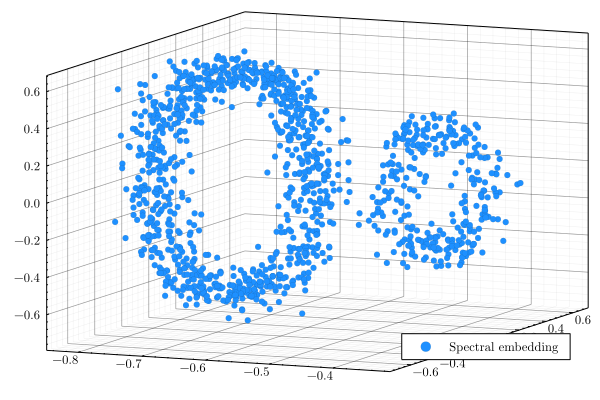

In [10]:
ϵ = 2
B = rdpg.edgeFlip(A; ϵ = 2)
Y, _ = @pipe B  |> (_ .- (rdpg.τ(ϵ)^2)) ./ (rdpg.σ(ϵ)^2) |> rdpg.spectralEmbed(_; d = 3, scale = false)
plt2 = @pipe Y |> rdpg._Matrix_to_ArrayOfTuples |> scatter(_, c = :dodgerblue, label = "Spectral embedding", legend = :bottomright)

### $k-$ Means clustering under differential privacy
----

Ordinarily, $k-$ Means clustering requires a tuning parameter $k$ specifying the number of clusters. We assume that the number of clusters $k=2$ is known *a priori*, and we perform clustering on the spectral embedding. The results are below. 

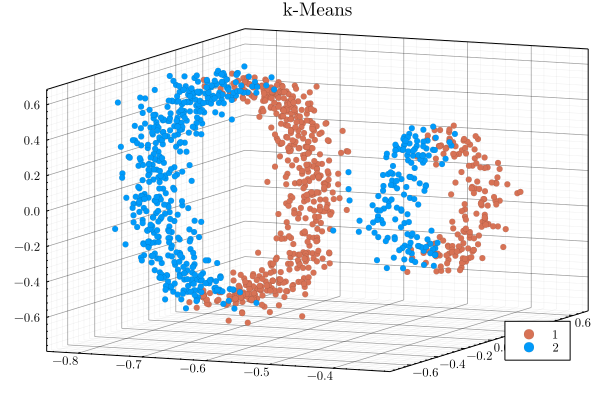

In [11]:
kmeans_labels = rdpg.cluster_embeddings(X, 2);
kmeans_plt = scatter(Y |> rdpg._Matrix_to_ArrayOfTuples, group = kmeans_labels, legend = :bottomright, title = "k-Means")

The results shown above are selecting the best clustering candidate based on $N=25$ random initializations based on the clustering silhouettes. Instead, we could also cluster based on the lowest misclassification error (assuming the true labels are also known a priori). The best result from $N=25$ random initilizations are shown below. 

In [12]:
function oracle_cluster_embeddings(X, d, labels)
    iter = 25
    best = -1
    clusters = nothing
    for i = 1:iter
        res = Clustering.kmeans(X', d)
        metric = mean(C1 .== labels)
        if metric > best
            best = metric
            clusters = res.assignments
        end
    end
    return clusters
end

kmeans_labels_alt = oracle_cluster_embeddings(X, 2, labels);
kmeans_plt2 = scatter(Y |> rdpg._Matrix_to_ArrayOfTuples, group = kmeans_labels_alt, legend = :bottomright, title = "k-Means")

UndefVarError: UndefVarError: C1 not defined

### Topology-aware clustering
----

[Chazal et al. (2013)](https://dblp.org/rec/journals/jacm/ChazalGOS13.html) proposed ToMATo clustering as an algorithm to overcome the drawbacks of $k-$ means clustering by forming clusters based on topological persistence. However, their methodology (Algorithm 1) requires the following tuning parameters: (1) A Kernel $\mathcal{K}(\cdot, \cdot)$ with bandwidth $\sigma$ density filtering, (2) the cutoff level $\tau$ of the density filtration, and (3) the resolution $\delta$ for the Rips complex. 

While their method is useful for robust clustering in the presence of outliers; we note that under differential privacy, from Propositions 3.3 and 3.4, no extraneous outliers are introduced. Therefore, we *propose the following simple clustering algorithm* inspired by ToMATo, which requires just one tuning parameter $q$.

#### Algorithm: Topology-Aware Clustering

* **Input:** Points $\mathbb{X}_n$ and a cutoff quantile $q$

1. Compute the persistence diagram $\mathfrak{D} = \mathfrak{Dgm}(\mathbb{X}_n)$
2. For all $i \in |\mathfrak{D}|$ **do**
    * Compute the total persistence $\Delta_i = |{b_i - d_i}|$ for the birth/death pair $(b_i, d_i) \in \mathfrak{D}$ 
    
    **end for**


3. Compute the median $m(\Delta)$ and the mean-absolute-deviation $\varsigma(\Delta)$ for the collection $\Delta = \{ \Delta_i : i \in |\mathfrak{D}| \}$
4. Initialize $\textsf{Clusters} = \varnothing$
5. For all $i \in |\mathfrak{D}|$ **do**
    * Compute the standardized score $\bar{\Delta}_i = |\Delta_i - m(\Delta)| / \varsigma(\Delta)$ for the birth/death pair $(b_i, d_i) \in \mathfrak{D}$ 
    
    * **If** $\bar{\Delta}_i > q$ 
        * Filter the simplex $\sigma$ with $(\text{birth}(\sigma), \text{death}(\sigma)) = \{(b_i, d_i)\}$

        * Extract the vertices of $V(\sigma) = \{\boldsymbol{x} : \boldsymbol{x} \in \sigma\}$
        
        * $\textsf{Clusters} = \textsf{Clusters} \bigcup \{V(\sigma)\}$
        
        **end if**
    
    **end for**

6. ***Return*** $\textsf{Clusters}$

In [13]:
function extract_vertices(d, f = Ripserer.representative)
    return @pipe d |> f .|> Ripserer.vertices |> map(x -> [x...], _) |> rdpg.t2m |> unique
end;

function stdscore(w)
    return [abs(x - mean(w)) / std(w) for x in w]
end;

function filterDgm(dgm; order = 1, ς=3, f = Ripserer.representative, vertex=true)
    u = Ripserer.persistence.(dgm[order][1:end-1])
    v = [0, u[1:end-1]...]
    w = u - v
    index = findall(x -> x > ς , stdscore(w))
    return vertex ? [extract_vertices(dgm[order][i...], f) for i in index] : index
end;

function dgmclust(dgm; order=1, threshold=3)
    idx = filterDgm(dgm, order = order, ς=threshold)
    K = length(idx)
    classes = repeat([0], length(dgm[1]))
    for k in K
        classes[idx[k]] .= k
    end
    return classes
end

dgmclust (generic function with 1 method)

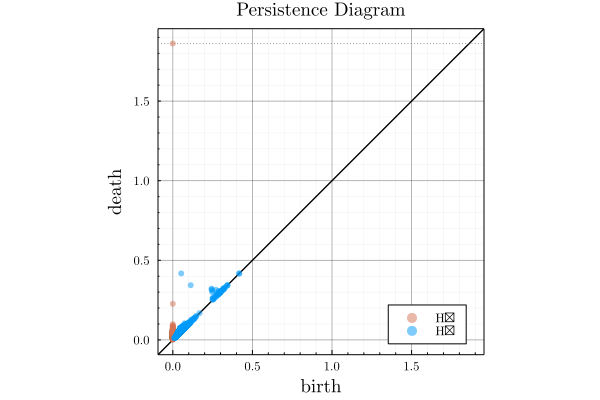

In [106]:
D = @pipe Y |> rdpg.m2t |> ripserer(Alpha(_), dim_max = 1, reps = true)
dgmplot =  plot(D)
@suppress display(dgmplot)

In [107]:
index1 = filterDgm(D, order = 1, vertex = false)
index2 = filterDgm(D, order = 2, vertex = false)

3-element Vector{Int64}:
 2214
 2216
 2219

In [ ]:
dgmplot_filtered = @pipe D[1][index2] |> plot(dgmplot, _, c = [:black], markeralpha=1)
@suppress display(dgmplot_filtered)